In [2]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import mpld3; from mpld3 import plugins
import datetime
import pandas_profiling

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

# Add this to python2 code to make life easier
from __future__ import absolute_import, division, print_function

/Applications/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Read Data

In [3]:
#df_station = pd.read_csv('201508_station_data.csv')
#df_status = pd.read_csv('201508_status_data.csv')
df_trip = pd.read_csv('201508_trip_data.csv')
#df_weather = pd.read_csv('201508_weather_data.csv')

## Which bike saw the most use over the entire period?

#### I am going to group the dataframe by the number of trips and find which bike is the one that has been used the most often:

In [5]:
trip_count = df_trip.groupby('Bike #')['Trip ID'].count().reset_index()

In [6]:
trip_count.sort_index(by='Trip ID', ascending=False, inplace=True)

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  if __name__ == '__main__':


In [68]:
trip_count.head(1)
print('The most used bike is id:', trip_count.head(1)['Bike #'].values[0])

The most used bike is id: 878


#### The most used bike is the one with the bike ID "878"

## Are customers or subscribers more likely to make round trips?
### If using a hypothesis test, please state your assumptions and give a p-value. If you find a significant difference, why do you think this might be the case?

#### First I'm going to separate the number of trips in round trips (trips having the same start and end terminal) and single trips.
#### Secondly, I will group them by the subscriber type, separating them into 'Subscriber' and 'Customer'.
#### I will estimate the ratio of 'Customers' doing a round trip vs 'Customers' doing single trips as well as the ratio of 'Subscribers' doing a round trip vs 'Subscribers' doing single trips.
#### Afterwards, I will apply a chi-square test of independence to find out if the difference between both ratios is statistically significant or not.

In [14]:
print(df_trip.columns)

single_trip = df_trip[df_trip['Start Terminal'] != df_trip['End Terminal']]
round_trip  = df_trip[df_trip['Start Terminal'] == df_trip['End Terminal']]

n_users_round_trip = round_trip.shape[0]
n_users_not_round_trip = df_trip.shape[0] - round_trip.shape[0]

print('There are ', n_users_round_trip/df_trip.shape[0]*100, '% round trips')

Index(['Trip ID', 'Duration', 'Start Date', 'Start Station', 'Start Terminal',
       'End Date', 'End Station', 'End Terminal', 'Bike #', 'Subscriber Type',
       'Zip Code'],
      dtype='object')
There are  2.9015789830355327 % round trips


In [16]:
round_trip_subscriber = round_trip[round_trip['Subscriber Type'] == 'Subscriber']
round_trip_customer = round_trip[round_trip['Subscriber Type'] == 'Customer']

single_trip_subcriber = single_trip[single_trip['Subscriber Type'] == 'Subscriber']
single_trip_customer = single_trip[single_trip['Subscriber Type'] == 'Customer']

prp_subscriber = round_trip_subscriber['Trip ID'].shape[0] / single_trip_subcriber['Trip ID'].shape[0]
prp_customer = round_trip_customer['Trip ID'].shape[0] / single_trip_customer['Trip ID'].shape[0]

print('Fraction of subscribers doing round trips:', prp_subscriber)
print('Fraction of customers doing round trips:', prp_customer)

Fraction of subscribers doing round trips: 0.011012325722368155
Fraction of customers doing round trips: 0.18621415843188077


In [17]:
## Chi-square Test of Independence
from scipy.stats import chi2_contingency

chi2, p_value, dof, exp = chi2_contingency(
    [[round_trip_subscriber['Trip ID'].shape[0], single_trip_subcriber['Trip ID'].shape[0]], \
     [round_trip_customer['Trip ID'].shape[0], single_trip_customer['Trip ID'].shape[0]] ])

In [18]:
print('The p-value is:', p_value)

The p-value is: 0.0


#### The p-value is the conditional probability (assuming that the null hypothesis is true) that the observed difference between both ratios is due to randomness. We typically want a p-value lower than 0.05 to discard the null hypothesis and confirm that the difference in the ratios is statistically significant. In this case, the p-value is much lower than 0.05, therefore we can reject the null hypothesis and conclude that there is a significant difference between customers and subscribers making round trips.
#### Considering that the ratio for 'Customers' is higher than the one of 'Subscribers', customers are more likely to make round trips.

## Provide a graph of daily trips over the period

#### I will group the trips by start date, so I can plot the "Trip ID" per day.

In [19]:
df_trip['Start Date'] = df_trip['Start Date'].apply(
    lambda x: datetime.date(int(x.split('/')[2][0:4]), 
                            int(x.split('/')[0]),
                            int(x.split('/')[1])))

In [20]:
n_trips_day = df_trip.groupby('Start Date')["Trip ID"].count().reset_index()

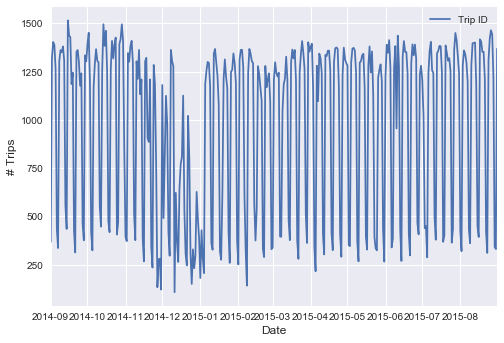

In [21]:
fig = plt.figure(figsize=(7,4))

n_trips_day.plot(x="Start Date", y="Trip ID",fontsize=10)
plt.xlabel('Date', fontsize=12); plt.ylabel('# Trips', fontsize=12)

plt.show()

## Are there usage pattern differences between weekday and weekend trips?

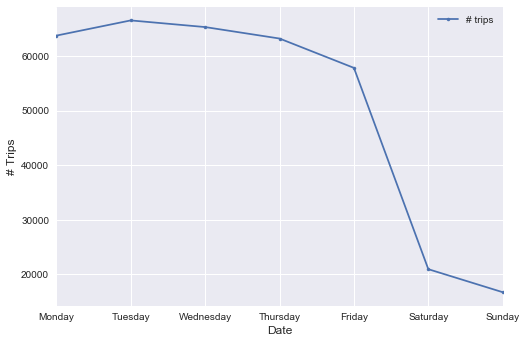

In [22]:
n_trips_day['dow'] = n_trips_day['Start Date'].apply(lambda x: x.weekday())

week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 
        5: 'Saturday', 6: 'Sunday'}

n_trips_dow = n_trips_day.groupby('dow')['Trip ID'].sum().reset_index()
n_trips_dow['dow'] = n_trips_dow['dow'].apply(lambda x: week[x])


fig = plt.figure(figsize=(7,4))

n_trips_dow.plot(x="dow", y="Trip ID",fontsize=10, marker='.', label='# trips')
plt.xlabel('Date', fontsize=12); plt.ylabel('# Trips', fontsize=12)

plt.show()

#### We can see that the number of trips decreases over the weekend and that the peak happens on 'Tuesday'

## What are some business ramifications of your findings?

#### Using the Prophet Facebook's package, let's forecast the number of trips per day in the next 60 days

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


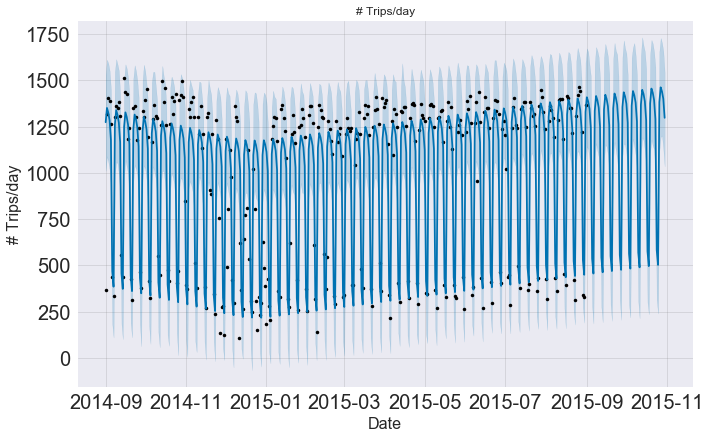

In [38]:
from fbprophet import Prophet

n_trips_day.columns

df = n_trips_day[['Start Date', 'Trip ID']]
df.columns = ['ds','y']

m = Prophet()
m.fit(df) ##Fit the dataset

#Predict
future_c = m.make_future_dataframe(periods=60)
future_c.tail()

#Forecast
forecast_c = m.predict(future_c)
forecast_c[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

m.plot(forecast_c);
plt.title('# Trips/day'); plt.xlabel('Date', fontsize=16), plt.ylabel('# Trips/day', fontsize=16)
plt.show()

#### We can see that the number of trips per day is likely going to increase in the next 60 days; therefore it would be useful to keep a good maintenance of the bikes.

#### Based on this expected increase in the number of trips, it would be useful to look into the different stations separately and find out which one need more bikes.

In [53]:
df_station = pd.read_csv('201508_station_data.csv')
print(df_station.columns)
print(df_trip.columns)

print(df_trip['Start Station'].head())
print(df_station[['station_id', 'name']].head())

#print(df_trip.shape, df_station.shape)
#print(df_trip.head(3), df_station.head(3))

Index(['station_id', 'name', 'lat', 'long', 'dockcount', 'landmark',
       'installation'],
      dtype='object')
Index(['Trip ID', 'Duration', 'Start Date', 'Start Station', 'Start Terminal',
       'End Date', 'End Station', 'End Terminal', 'Bike #', 'Subscriber Type',
       'Zip Code'],
      dtype='object')
0    Harry Bridges Plaza (Ferry Building)
1             San Antonio Shopping Center
2                          Post at Kearny
3                      San Jose City Hall
4                   Embarcadero at Folsom
Name: Start Station, dtype: object
   station_id                               name
0           2  San Jose Diridon Caltrain Station
1           3              San Jose Civic Center
2           4             Santa Clara at Almaden
3           5                   Adobe on Almaden
4           6                   San Pedro Square


In [61]:
## Check that all stations have information for the whole period:
station_first_date = df_trip.groupby('Start Station')['Start Date'].min().reset_index()
print(station_first_date['Start Date'].min(), station_first_date['Start Date'].max())


2014-09-01
2014-09-26


There are 25 days difference between the first recorded trip in each station, but as a first approximation that is not an issue.

In [69]:
station_popularity = df_trip.groupby('Start Station')['Trip ID'].count().reset_index()

station_popularity.sort_index(by='Trip ID', ascending=False, inplace=True)

print('The most popular station is:', station_popularity.head(1))
print('The least popular station is:', station_popularity.tail(1))

The most popular station is:                                Start Station  Trip ID
49  San Francisco Caltrain (Townsend at 4th)    26304
The least popular station is:         Start Station  Trip ID
20  Franklin at Maple       81


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  app.launch_new_instance()


#### In the future, one may consider to relocate bikes from 'Franklin at Maple' to 'San Francisco Caltrain'

#### I would also expect the weather to affect the usage of bikes. Given more time, I could look into the temperature of the different areas and associate it to the number of trips starting and ending in this region.

In [39]:
df_weather = pd.read_csv('201508_weather_data.csv')

In [40]:
df_weather.columns
#print(df_trip.shape, df_weather.shape)

Index(['PDT', 'Max TemperatureF', 'Mean TemperatureF', 'Min TemperatureF',
       'Max Dew PointF', 'MeanDew PointF', 'Min DewpointF', 'Max Humidity',
       ' Mean Humidity', ' Min Humidity', ' Max Sea Level PressureIn',
       ' Mean Sea Level PressureIn', ' Min Sea Level PressureIn',
       ' Max VisibilityMiles', ' Mean VisibilityMiles', ' Min VisibilityMiles',
       ' Max Wind SpeedMPH', ' Mean Wind SpeedMPH', ' Max Gust SpeedMPH',
       'PrecipitationIn', ' CloudCover', ' Events', ' WindDirDegrees', 'Zip'],
      dtype='object')